In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
import numpy as np

def deutsch_jozsa_oracle(n, oracle_type="balanced"):
    oracle = QuantumCircuit(n+1)
    
    if oracle_type == "o0": 
        oracle.cx(0, n)
    elif oracle_type == "o1":
        oracle.cx(1, n)
    elif oracle_type == "o2": 
        oracle.cx(0, n)
        oracle.cx(1, n)
    elif oracle_type == "o3": 
        pass  
    elif oracle_type == "o4": 
        oracle.x(n)

    return oracle

H_faulty = (1/np.sqrt(2)) * np.array([[1, 1],
                                      [-1, 1]])

faulty_h_gate = UnitaryGate(H_faulty, label="H_f")

def deutsch_jozsa_algorithm(n, oracle_type="balanced", 
                            faulty_first=None, faulty_second=None):
    dj_circuit = QuantumCircuit(n+1, n)


    dj_circuit.x(n)
    dj_circuit.h(n)

  
    for i in range(n):
        if faulty_first and i in faulty_first:
            dj_circuit.append(faulty_h_gate, [i])
        else:
            dj_circuit.h(i)

   
    oracle = deutsch_jozsa_oracle(n, oracle_type)
    dj_circuit.compose(oracle, inplace=True)

  
    for i in range(n):
        if faulty_second and i in faulty_second:
            dj_circuit.append(faulty_h_gate, [i])
        else:
            dj_circuit.h(i)

   
    dj_circuit.measure(range(n), range(n))

    return dj_circuit


In [46]:
dj_circuit = deutsch_jozsa_algorithm(2, oracle_type="o4", faulty_first=[1])


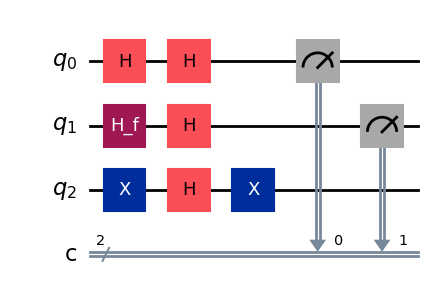

In [47]:
dj_circuit.draw(output="mpl")

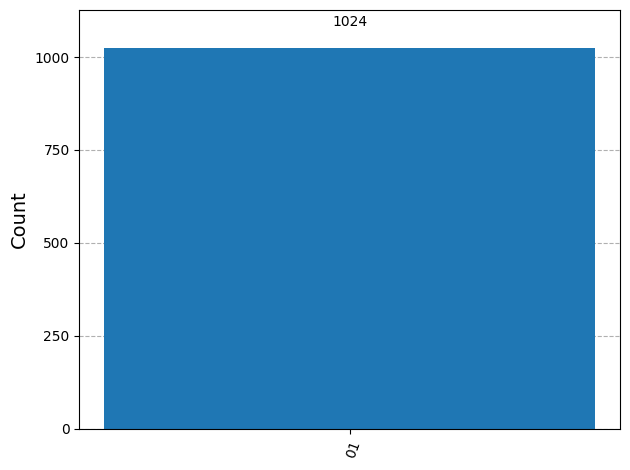

In [72]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(dj_circuit, shots = 1024).result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
service= QiskitRuntimeService(channel="ibm_cloud", 
                              token="........",
                              instance="..........")
backend_qc= service.backend(name="ibm_brisbane")


In [48]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm= generate_preset_pass_manager(optimization_level=1, backend=backend_qc)
transpilated_circuit= pm.run(dj_circuit)

In [49]:
sampler= Sampler(mode= backend_qc)

In [50]:
job= sampler.run([transpilated_circuit])

In [55]:
job.status()

'DONE'

In [56]:
result= job.result()
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-08-20 18:55:51', stop='2025-08-20 18:55:53', size=4096>)])}, 'version': 2})


{'10': 3705, '11': 313, '00': 70, '01': 8}


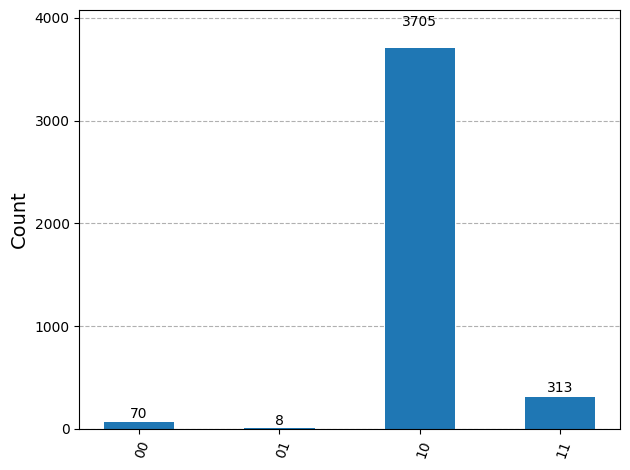

In [57]:
dj_circuit.cregs
counts= result[0].data['c'].get_counts()
print(counts)
plot_histogram(counts)

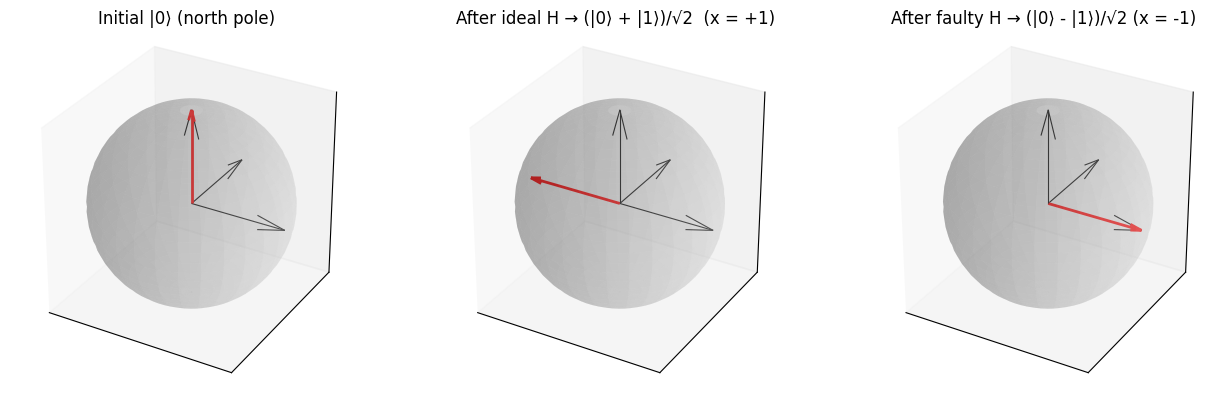

Bloch vectors (x, y, z):
Initial: [0. 0. 1.]
Ideal H: [-1.  0.  0.]
Faulty H: [1. 0. 0.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate

H_faulty = (1/np.sqrt(2)) * np.array([[1, 1],
                                      [-1, 1]])
faulty_h_gate = UnitaryGate(H_faulty, label="H_f")

sv0 = Statevector.from_label("0")

qc_ideal = QuantumCircuit(1)
qc_ideal.h(0)
sv_ideal = sv0.evolve(qc_ideal)

qc_faulty = QuantumCircuit(1)
qc_faulty.append(faulty_h_gate, [0])
sv_faulty = sv0.evolve(qc_faulty)


def bloch_vector_from_statevector(sv):

    a = sv.data[0]
    b = sv.data[1]
    x = 2 * np.real(np.conj(a) * b)
    y = 2 * np.imag(np.conj(a) * b)
    z = np.abs(a)**2 - np.abs(b)**2
    return np.array([x, y, z])

v_init   = bloch_vector_from_statevector(sv0)
v_ideal  = bloch_vector_from_statevector(sv_ideal)
v_faulty = bloch_vector_from_statevector(sv_faulty)


def plot_bloch(ax, vec, title=""):
   
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    uu, vv = np.meshgrid(u, v)
    x = np.cos(uu) * np.sin(vv)
    y = np.sin(uu) * np.sin(vv)
    z = np.cos(vv)
    ax.plot_surface(x, y, z, color="lightgray", alpha=0.25, linewidth=0)

  
    ax.quiver(0,0,0, 1,0,0, length=1, normalize=True, color="k", linewidth=0.8)
    ax.quiver(0,0,0, 0,1,0, length=1, normalize=True, color="k", linewidth=0.8)
    ax.quiver(0,0,0, 0,0,1, length=1, normalize=True, color="k", linewidth=0.8)

   
    ax.quiver(0,0,0, vec[0], vec[1], vec[2],
              length=1.0, normalize=False, color="r",
              linewidth=2, arrow_length_ratio=0.12)

 
    ax.set_xlim([-1.0, 1.0]); ax.set_ylim([-1.0, 1.0]); ax.set_zlim([-1.0, 1.0])
    ax.set_box_aspect([1,1,1]) 
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])


fig = plt.figure(figsize=(13, 4))
axs = [fig.add_subplot(1, 3, i+1, projection="3d") for i in range(3)]

plot_bloch(axs[0], v_init,   title="Initial |0⟩ (north pole)")
plot_bloch(axs[1], v_ideal,  title="After ideal H → (|0⟩ + |1⟩)/√2  (x = +1)")
plot_bloch(axs[2], v_faulty, title="After faulty H → (|0⟩ - |1⟩)/√2 (x = -1)")

plt.tight_layout()
plt.show()


print("Bloch vectors (x, y, z):")
print("Initial:", np.round(v_init, 3))
print("Ideal H:", np.round(v_ideal, 3))
print("Faulty H:", np.round(v_faulty, 3))


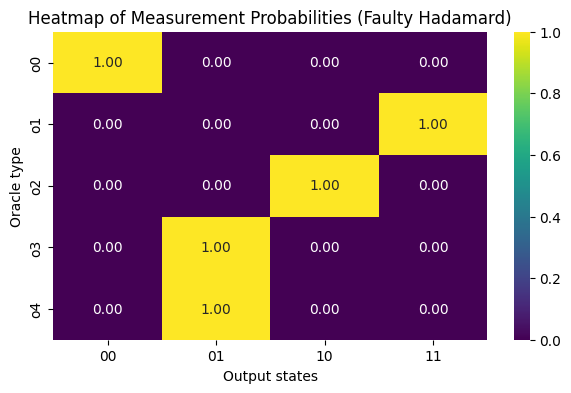

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def deutsch_jozsa_oracle(n, oracle_type="balanced"):
    oracle = QuantumCircuit(n+1)
    if oracle_type == "o0":    
        oracle.cx(0, n)
    elif oracle_type == "o1":    
        oracle.cx(1, n)
    elif oracle_type == "o2":   
        oracle.cx(0, n)
        oracle.cx(1, n)
    elif oracle_type == "o3":   
        pass
    elif oracle_type == "o4":    
        oracle.x(n)
    return oracle


H_faulty = (1/np.sqrt(2)) * np.array([[1, 1],
                                      [-1, 1]])
faulty_h_gate = UnitaryGate(H_faulty, label="H_f")


def deutsch_jozsa_algorithm(n, oracle_type="balanced", 
                            faulty_first=None, faulty_second=None):
    qc = QuantumCircuit(n+1, n)
    qc.x(n)
    qc.h(n)

   
    for i in range(n):
        if faulty_first and i in faulty_first:
            qc.append(faulty_h_gate, [i])
        else:
            qc.h(i)

    qc.compose(deutsch_jozsa_oracle(n, oracle_type), inplace=True)

    for i in range(n):
        if faulty_second and i in faulty_second:
            qc.append(faulty_h_gate, [i])
        else:
            qc.h(i)

    qc.measure(range(n), range(n))
    return qc


sim = AerSimulator()
shots = 2000
oracles = ["o0", "o1", "o2", "o3", "o4"]

def run_case(fault_case):
    probs = {}
    for o in oracles:
        qc = deutsch_jozsa_algorithm(2, oracle_type=o, **fault_case)
        result = sim.run(qc, shots=shots).result()
        counts = result.get_counts()
      
        total = sum(counts.values())
        probs[o] = {k: v/total for k,v in counts.items()}
    return probs


fault_case = {"faulty_first":[0]}  
probs = run_case(fault_case)


all_states = sorted(set().union(*[p.keys() for p in probs.values()]))


matrix = []
for o in oracles:
    row = []
    for s in all_states:
        row.append(probs[o].get(s, 0))
    matrix.append(row)

plt.figure(figsize=(7,4))
sns.heatmap(matrix, annot=True, cmap="viridis", xticklabels=all_states, yticklabels=oracles, cbar=True, fmt=".2f")
plt.xlabel("Output states")
plt.ylabel("Oracle type")
plt.title("Heatmap of Measurement Probabilities (Faulty Hadamard)")
plt.show()

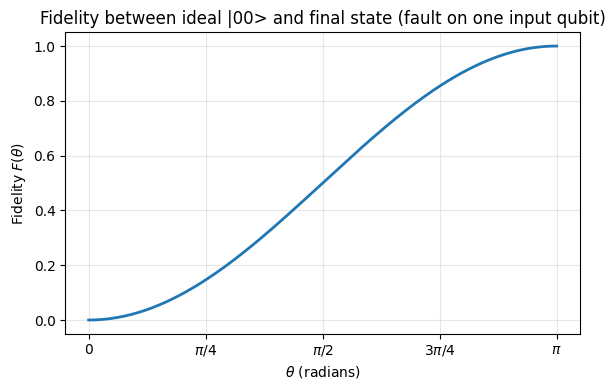

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fidelity_theta(theta):

    return 0.5 * (1 - np.cos(theta))

thetas = np.linspace(0, np.pi, 201)
F = fidelity_theta(thetas)

plt.figure(figsize=(6,4))
plt.plot(thetas, F, lw=2)
plt.xlabel(r'$\theta$ (radians)')
plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi],
           [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
plt.ylabel('Fidelity $F(\\theta)$')
plt.title('Fidelity between ideal |00> and experimental final state')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
